In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop



import numpy as np
import matplotlib.pyplot as plt
import pathlib
from tensorflow import keras

In [3]:
def train_val_generators(TRAINING_DIR, TESTING_DIR):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest'
                                      )
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=15,
                                                       class_mode='categorical',
                                                       target_size=(150,150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                  batch_size=15,
                                                                 class_mode='categorical',
                                                                 target_size=(150, 150))
    
    return train_generator, validation_generator

In [4]:
TRAINING_DIR = "../ROBOTSDATASET/training/"
TESTING_DIR = "../ROBOTSDATASET/testing/"
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 7488 images belonging to 20 classes.
Found 1880 images belonging to 20 classes.


# MobileNetV2

In [85]:
pre_trained_model = MobileNetV2(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights='imagenet'
                               )

In [86]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [87]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [88]:
last_layer = pre_trained_model.get_layer('block_15_add')
last_output = last_layer.output
last_output

<KerasTensor: shape=(None, 5, 5, 160) dtype=float32 (created by layer 'block_15_add')>

In [89]:
x = tf.keras.layers.Flatten()(last_output)
x= tf.keras.layers.Dense(128, activation='relu')(x)
x= tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(20, activation='softmax')(x)

model_1 = Model(pre_trained_model.input, x)

model_1.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [90]:
# Set the training parameters
model_1.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [91]:
# Train the model
history_1 = model_1.fit(train_generator, epochs=25, steps_per_epoch=15, validation_data = validation_generator, validation_steps=3)

Epoch 1/25
15/15 [==============================] - 11s 441ms/step - loss: 7.3107 - accuracy: 0.0489 - val_loss: 3.3430 - val_accuracy: 0.0667
Epoch 2/25
15/15 [==============================] - 5s 313ms/step - loss: 3.2253 - accuracy: 0.0533 - val_loss: 3.2644 - val_accuracy: 0.0889
Epoch 3/25
15/15 [==============================] - 5s 304ms/step - loss: 3.2656 - accuracy: 0.0489 - val_loss: 3.4891 - val_accuracy: 0.0667
Epoch 4/25
15/15 [==============================] - 5s 320ms/step - loss: 3.2165 - accuracy: 0.0578 - val_loss: 3.0567 - val_accuracy: 0.1778
Epoch 5/25
15/15 [==============================] - 5s 315ms/step - loss: 3.1553 - accuracy: 0.0978 - val_loss: 3.1881 - val_accuracy: 0.0667
Epoch 6/25
15/15 [==============================] - 5s 349ms/step - loss: 3.1057 - accuracy: 0.0489 - val_loss: 3.1414 - val_accuracy: 0.0667
Epoch 7/25
15/15 [==============================] - 5s 363ms/step - loss: 3.0349 - accuracy: 0.0978 - val_loss: 3.4028 - val_accuracy: 0.0444
Epoch

# Sequential Model

In [93]:
import tensorflow as tf

model_2 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(20, activation='softmax')
])

# Print the model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_188 (Conv2D)         (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_189 (Conv2D)         (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_190 (Conv2D)         (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)      0

In [94]:
# Set the training parameters
model_2.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [95]:
# Train the model
history_2 = model_2.fit(train_generator, epochs=25, steps_per_epoch=15, validation_data = validation_generator, validation_steps=3)

Epoch 1/25
15/15 [==============================] - 12s 724ms/step - loss: 3.3031 - accuracy: 0.0756 - val_loss: 3.0536 - val_accuracy: 0.0667
Epoch 2/25
15/15 [==============================] - 11s 741ms/step - loss: 3.0578 - accuracy: 0.1067 - val_loss: 3.0119 - val_accuracy: 0.0667
Epoch 3/25
15/15 [==============================] - 11s 726ms/step - loss: 3.0297 - accuracy: 0.0800 - val_loss: 3.0194 - val_accuracy: 0.0667
Epoch 4/25
15/15 [==============================] - 11s 722ms/step - loss: 3.0467 - accuracy: 0.0578 - val_loss: 3.0078 - val_accuracy: 0.0889
Epoch 5/25
15/15 [==============================] - 11s 721ms/step - loss: 3.0398 - accuracy: 0.0711 - val_loss: 3.0978 - val_accuracy: 0.0667
Epoch 6/25
15/15 [==============================] - 11s 741ms/step - loss: 3.0475 - accuracy: 0.1244 - val_loss: 3.0117 - val_accuracy: 0.0889
Epoch 7/25
15/15 [==============================] - 10s 687ms/step - loss: 3.1928 - accuracy: 0.0711 - val_loss: 3.0438 - val_accuracy: 0.1333

# MobileNetV2 2

In [96]:
x = tf.keras.layers.Flatten()(last_output)
x= tf.keras.layers.Dense(128, activation='relu')(x)
x= tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(20, activation='softmax')(x)

model_3 = Model(pre_trained_model.input, x)

model_3.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [97]:
# Set the training parameters
model_3.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [98]:
# Train the model
history_3 = model_3.fit(train_generator, epochs=25, steps_per_epoch=15, validation_data = validation_generator, validation_steps=3)

Epoch 1/25
15/15 [==============================] - 21s 550ms/step - loss: 9.3532 - accuracy: 0.0489 - val_loss: 3.5420 - val_accuracy: 0.0000e+00
Epoch 2/25
15/15 [==============================] - 6s 398ms/step - loss: 3.2881 - accuracy: 0.1022 - val_loss: 3.3314 - val_accuracy: 0.0000e+00
Epoch 3/25
15/15 [==============================] - 5s 336ms/step - loss: 3.3096 - accuracy: 0.1111 - val_loss: 2.9322 - val_accuracy: 0.1333
Epoch 4/25
15/15 [==============================] - 6s 367ms/step - loss: 3.2721 - accuracy: 0.0622 - val_loss: 2.8648 - val_accuracy: 0.1556
Epoch 5/25
15/15 [==============================] - 5s 359ms/step - loss: 3.1201 - accuracy: 0.0667 - val_loss: 3.3947 - val_accuracy: 0.1111
Epoch 6/25
15/15 [==============================] - 5s 359ms/step - loss: 3.0551 - accuracy: 0.1067 - val_loss: 3.3709 - val_accuracy: 0.0667
Epoch 7/25
15/15 [==============================] - 5s 361ms/step - loss: 3.0428 - accuracy: 0.1111 - val_loss: 2.8905 - val_accuracy: 0.17

# InceptionV3

In [11]:


# Set the weights file you downloaded into a variable
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model_inception = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None,
                                             )

pre = InceptionV3
# Load the pre-trained weights you downloaded.
pre_trained_model_inception.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model_inception.layers:
    layer.trainable = False

In [12]:
pre_trained_model_inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

 batch_normalization_104 (Batch  (None, 16, 16, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 16, 16, 32)  96          ['conv2d_105[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_99 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_99[0][0]'] 
                                                                                                  
 activation_101 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_101[0][0]']
                                                                                                  
 activatio

 conv2d_114 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_normalization_114 (Batch  (None, 16, 16, 48)  144         ['conv2d_114[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_117 (Batch  (None, 16, 16, 96)  288         ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 conv2d_128 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 7, 7, 128)   384         ['conv2d_128[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_128 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_128[0][0]']
                                                                                                  
 conv2d_129 (Conv2D)            (None, 7, 7, 128)    114688      ['activation_128[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_138 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_138[0][0]']         
                                                                                                  
 batch_normalization_139 (Batch  (None, 7, 7, 160)   480         ['conv2d_139[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_139 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_13

 batch_normalization_149 (Batch  (None, 7, 7, 160)   480         ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_149[0][0]']
                                                                                                  
 conv2d_145 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_150 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_149[0][0]']         
                                                                                                  
 batch_normalization_145 (Batch  (None, 7, 7, 160)   480         ['conv2d_145[0][0]']             
 Normaliza

 conv2d_155 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_159[0][0]']         
                                                                                                  
 batch_normalization_155 (Batch  (None, 7, 7, 192)   576         ['conv2d_155[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_160 (Batch  (None, 7, 7, 192)   576         ['conv2d_160[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 7, 7, 192)   576         ['conv2d_168[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_164 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_164[0][0]']
                                                                                                  
 activation_168 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_168[0][0]']
                                                                                                  
 conv2d_165 (Conv2D)            (None, 3, 3, 320)    552960      ['activation_164[0][0]']         
          

                                                                                                  
 activation_176 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_177[0][0]']
                                                                                                  
 batch_normalization_178 (Batch  (None, 3, 3, 192)   576         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_170 (Activation)    (None, 3, 3, 320)    0           ['batch_normalization_170[0][0]']
                                                                                                  
 mixed9_0 

 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 3, 3, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_181[0][0]',         
                                                                  'activation_182[0][0]']         
                                                                                                  
 concatenate_3 (Concatenate)    (None, 3, 3, 768)    0           ['activation_185[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 activatio

In [13]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model_inception.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [14]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dropout(0.2)(x) 
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (20, activation='softmax')(x)           

# Append the dense network to the base model
model_4 = Model(pre_trained_model_inception.input, x) 

model_4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

 batch_normalization_104 (Batch  (None, 16, 16, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 16, 16, 32)  96          ['conv2d_105[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_99 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_99[0][0]'] 
                                                                                                  
 activation_101 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_101[0][0]']
                                                                                                  
 activatio

 conv2d_114 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_normalization_114 (Batch  (None, 16, 16, 48)  144         ['conv2d_114[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_117 (Batch  (None, 16, 16, 96)  288         ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 conv2d_128 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 7, 7, 128)   384         ['conv2d_128[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_128 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_128[0][0]']
                                                                                                  
 conv2d_129 (Conv2D)            (None, 7, 7, 128)    114688      ['activation_128[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_138 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_138[0][0]']         
                                                                                                  
 batch_normalization_139 (Batch  (None, 7, 7, 160)   480         ['conv2d_139[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_139 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_13

 batch_normalization_149 (Batch  (None, 7, 7, 160)   480         ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_149[0][0]']
                                                                                                  
 conv2d_145 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_150 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_149[0][0]']         
                                                                                                  
 batch_normalization_145 (Batch  (None, 7, 7, 160)   480         ['conv2d_145[0][0]']             
 Normaliza

 conv2d_155 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_159[0][0]']         
                                                                                                  
 batch_normalization_155 (Batch  (None, 7, 7, 192)   576         ['conv2d_155[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_160 (Batch  (None, 7, 7, 192)   576         ['conv2d_160[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

In [15]:
model_4.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [16]:
# Train the model.
history_4 = model_4.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 75,
            )

Epoch 1/75
500/500 [==============================] - 546s 1s/step - loss: 1.9655 - accuracy: 0.4159 - val_loss: 1.2935 - val_accuracy: 0.6133
Epoch 2/75
500/500 [==============================] - 555s 1s/step - loss: 1.5330 - accuracy: 0.5315 - val_loss: 1.3330 - val_accuracy: 0.5835
Epoch 3/75
500/500 [==============================] - 524s 1s/step - loss: 1.4017 - accuracy: 0.5696 - val_loss: 1.1796 - val_accuracy: 0.6324
Epoch 4/75
500/500 [==============================] - 481s 963ms/step - loss: 1.3369 - accuracy: 0.5967 - val_loss: 1.2018 - val_accuracy: 0.6527
Epoch 5/75
500/500 [==============================] - 485s 969ms/step - loss: 1.2847 - accuracy: 0.6206 - val_loss: 1.1450 - val_accuracy: 0.6351
Epoch 6/75
500/500 [==============================] - 498s 995ms/step - loss: 1.2456 - accuracy: 0.6254 - val_loss: 1.1264 - val_accuracy: 0.6585
Epoch 7/75
500/500 [==============================] - 494s 987ms/step - loss: 1.2178 - accuracy: 0.6317 - val_loss: 1.1284 - val_accu

Epoch 57/75
500/500 [==============================] - 469s 938ms/step - loss: 0.8329 - accuracy: 0.7783 - val_loss: 1.4878 - val_accuracy: 0.6952
Epoch 58/75
500/500 [==============================] - 468s 935ms/step - loss: 0.8184 - accuracy: 0.7867 - val_loss: 1.4803 - val_accuracy: 0.6899
Epoch 59/75
500/500 [==============================] - 470s 940ms/step - loss: 0.8303 - accuracy: 0.7780 - val_loss: 1.5493 - val_accuracy: 0.6782
Epoch 60/75
500/500 [==============================] - 471s 941ms/step - loss: 0.8437 - accuracy: 0.7802 - val_loss: 1.5417 - val_accuracy: 0.6968
Epoch 61/75
500/500 [==============================] - 470s 939ms/step - loss: 0.8369 - accuracy: 0.7814 - val_loss: 1.5413 - val_accuracy: 0.6931
Epoch 62/75
500/500 [==============================] - 568s 1s/step - loss: 0.8276 - accuracy: 0.7873 - val_loss: 1.5752 - val_accuracy: 0.6915
Epoch 63/75
500/500 [==============================] - 638s 1s/step - loss: 0.8302 - accuracy: 0.7849 - val_loss: 1.5788 

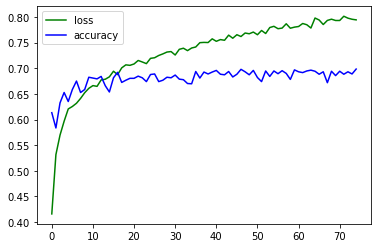

In [17]:
plt.plot(history_4.history['accuracy'], color='g')
plt.plot(history_4.history['val_accuracy'], color='b')
plt.legend(history_4.history)

In [303]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [307]:
# Set the weights file you downloaded into a variable
local_weights_file = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model_resnet = ResNet50(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model_resnet.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model_resnet.layers:
    layer.trainable = False

In [308]:
pre_trained_model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_27[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 38, 38, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 5, 5, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [309]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model_resnet.get_layer('conv4_block5_add')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 10, 10, 1024)


In [310]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (12, activation='sigmoid')(x)           

# Append the dense network to the base model
model_5 = Model(pre_trained_model_resnet.input, x) 

model_5.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_27[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 38, 38, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

In [312]:
model_5.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [314]:
# Train the model.
history_5 = model_5.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 25,
            )

Epoch 1/25
128/128 [==============================] - 356s 3s/step - loss: 9.8425 - accuracy: 0.0787 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 2/25
128/128 [==============================] - 335s 3s/step - loss: 2.5760 - accuracy: 0.0855 - val_loss: 3.1765 - val_accuracy: 0.0832
Epoch 3/25
128/128 [==============================] - 356s 3s/step - loss: 2.5486 - accuracy: 0.0896 - val_loss: 2.4849 - val_accuracy: 0.0852
Epoch 4/25
128/128 [==============================] - 339s 3s/step - loss: 2.5491 - accuracy: 0.0844 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 5/25
128/128 [==============================] - 309s 2s/step - loss: 2.5258 - accuracy: 0.0797 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 6/25
128/128 [==============================] - 301s 2s/step - loss: 2.5293 - accuracy: 0.0730 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 7/25
128/128 [==============================] - ETA: 0s - loss: 2.5050 - accuracy: 0.0776

KeyboardInterrupt: 

In [317]:
h_1 = history_1.history['accuracy'][-1]
h_2  = history_2.history['accuracy'][-1]
h_3 = history_3.history['accuracy'][-1]
h_4 = history_4.history['accuracy'][-1]

In [318]:
df = pd.DataFrame({'Model':['MobileNetV2', 'Sequential_13', 'MobileNetV2', 'InceptionV3'], 'Accuracy':[h_1,  h_2, h_3,  h_4 ]})

In [319]:
df.head()

,Model,Accuracy
0,MobileNetV2,0.573333
1,Sequential_13,0.217778
2,MobileNetV2,0.535714
3,InceptionV3,0.880667


In [320]:
pd.DataFrame.to_csv(df, "Experimental_robots_dataset.csv")

In [18]:
model_4.save('models/experimental/model_4_robots_balanced_20')

INFO:tensorflow:Assets written to: models/experimental/model_4_robots_balanced_20\assets


In [35]:
# Load in the SavedModel format
saved_model = tf.keras.models.load_model('models/experimental/model_4_robots_balanced_20')

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
19


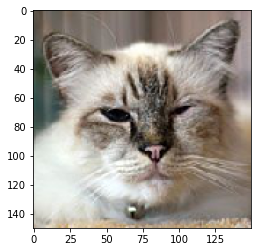

In [110]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = "../ROBOTSDATASET/testing/birman/21034784_627.jpg"

img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
print(model_4.predict(x))
print(np.argmax(model_4.predict(x)))

plt.imshow(img)



In [72]:
train_generator.class_indices

{'abyssinian': 0,
 'bengal': 1,
 'birman': 2,
 'bombay': 3,
 'british_shorthair': 4,
 'calico': 5,
 'dilute_calico': 6,
 'domestic_long_hair': 7,
 'domestic_short_hair': 8,
 'egyptian_mau': 9,
 'himalayan': 10,
 'maine_coon': 11,
 'persian': 12,
 'ragdoll': 13,
 'russian_blue': 14,
 'scottish_fold': 15,
 'siamese': 16,
 'sphynx': 17,
 'tonkinese': 18,
 'turkish_angora': 19,
 'tuxedo': 20}

In [338]:
list_of_class = [key for  key,value in train_generator.class_indices.items()]
list_of_class

['abyssinian',
 'bengal',
 'birman',
 'bombay',
 'british_shorthair',
 'egyptian_mau',
 'maine_coon',
 'persian',
 'ragdoll',
 'russian_blue',
 'siamese',
 'sphynx']

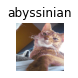

In [353]:
# import os
# def visualize_classification(imgpath):
#     img_path = f"../ROBOTSDATASET/testing/{imgpath}/"
#     for f in os.listdir(img_path):
#         file_path = img_path + f
#         img = image.load_img(file_path, target_size=(150, 150))
#         x = image.img_to_array(img)
#         x = np.expand_dims(x, axis=0)
#         plt.subplot(3,6,4)
# #         plt.title(f)
#         plt.axis('off')
#         plt.imshow(img)
#         plt.title(list_of_class[np.argmax(model_4.predict(x))])
        
# #     plt.show()
# visualize_classification('abyssinian')
        

    


In [19]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [20]:
export_dir = 'model_2'
tf.saved_model.save(model_4, export_dir)

INFO:tensorflow:Assets written to: model_2\assets


In [21]:

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [22]:
tflite_model_file = pathlib.Path('model_2.tflite')
tflite_model_file.write_bytes(tflite_model)

47777616

In [23]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()



In [24]:
import os

with open('labels.txt', 'w') as f:
    for label in os.listdir('../ROBOTSDATASET/training/'):
        f.writelines(f'{label}\n')